In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import Max_Ent_aux_lib as me
#import proj_ev_library as projev
#import max_entev library as meev
from IPython.display import display, Math, Latex

np.set_printoptions(threshold=1.e-3,linewidth=120,precision=1, formatter={"float":lambda x: str(.001*int(1000*x)) })

Tenemos la siguiente ecuación de movimiento:

$$
    \dot{c}_M(t) I_{M}^{0}(t) = -i \bigg\{\bigg(c_{M+2}(t) - c_M(t) \bigg)\langle \rho_{M}^{0\dagger}(t) [H_{0,-2}, \rho_{M+2}^0] \rangle + \bigg(c_{M-2}(t) - c_M(t)\bigg) \langle \rho_{M}^{0\dagger}(t) [H_{0,2}, \rho_{M-2}^0] \rangle + p \langle \rho_{M}^{0\dagger}(t) [\Sigma, \rho_{M}^0 (t)]\rangle \bigg\}
$$

siendo $I_{M}^{0}(t) = \langle \rho_{M}^{0\dagger}(t) \rho_{M}^{0}(t)\rangle = I_{-M}^{0}(t)$
la cual puede reescribirse como 

$$
\dot{c}_M(t) I_{M}^{0}(t) = -i \bigg\{A_{\rho^{M, M+2}} c_{M+2}(t) - \bigg(A_{\rho^{M, M+2}} + B_{\rho^{M, M-2}} \bigg) c_{M}(t) + B_{\rho^{M, M-2}} c_{M-2}(t) \bigg\} + p C_{\rho^M} \\
= - i{\bf{\mathcal{M}}}(t) \textbf{c}(t)
$$

donde 

<ol>

<li> $A_{\rho^{M, M+2}} = \langle \rho_{M}^{0\dagger}(t) [H_{0,-2}, \rho_{M+2}^0] \rangle$ </li> 
<li> $B_{\rho^{M, M-2}} = \langle \rho_{M}^{0\dagger}(t) [H_{0,2}, \rho_{M-2}^0] \rangle$ </li>
<li> $C_{\rho^M} = \langle \rho_{M}^{0\dagger}(t) [\Sigma, \rho_{M}^0 (t)]\rangle$ </li>
    
</ol>    

Entonces, si $f(t) = \langle \rho(t) \rho^0(t) \rangle = \sum_{M} \dot{c}_M(t) I_{M}^{0}(t)$

$$
    \dot{f}(t) = \sum_{M} \bigg(\dot{c}_M(t) I_{M}^{0}(t) + {c}_M(t) \dot{I}_{M}^{0}(t) \bigg)
$$

where

1: $A=\alpha B = N(t) \exp(-m t^{1+a}) = I_M^{(0)}$ (a primer orden alpha = 1) \
2: $C = M N(t) exp(-m t^{1+a})$

con $N(t) = 1/Tr(\rho(t))$ la calculo con la definición del $\rho_M (t)=  c_{M}(t) \rho^0_M(t)$, with $c_0(t)$= 1. 
Note that the kernel $K(t,t') = e^{(-i M(t-t'))}$ is not a solution to the previous differential equation for the M-tensor is time-dependent
    
$H_ {0, 2}^\dagger = H_{0, -2}$ 

$\rho_{M}^\dagger = rho{-M}$

## Step 1: Fix parameters and initial conditions for the coherences

In [13]:
p = .0009;    # strength of the Sigma Interaction Hamiltonian
a = .05;      # Power-law factor
M = 600;      # Truncation/Total no. of coherences
coherences_t0_pert0 = 1. # Unused for the time being
param_list = {"total_no_cohrs": M, "p_factor": p, "power_law_factor": a} # dictionary containing the simulation's initial 
                                                                         # parameters 

coeff_list_t0 = np.array([coherences_t0_pert0 - np.random.rand() for i in range(param_list["total_no_cohrs"])])
              # initial configuration for the coherences, random numbers for the time being. Can be changed in the future

coeff_list_t0 = coeff_list_t0/(sum(coeff_list_t0)) 
              # normalization of the initial vector, so that Tr c_0 = 1. 

## Step 1. bis: A simple verification for the hermitian-ness and general form of the M-tensor

In [17]:
M_tensor_f= np.array(me.gen_func_even_cohr_M_matrix(param_list, coeff_list_t0, 1, False, False, False))
qutip.Qobj(M_tensor_f)
     #* TODO: not hermitian, fix later. 

Quantum object: dims = [[600], [600]], shape = (600, 600), type = oper, isherm = False
Qobj data =
[[0.11900000000000001 0.88 0.0 ... 0.0 0.0 0.0]
 [0.156 -0.312 1.156 ... 0.0 0.0 0.0]
 [0.0 0.156 -0.312 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... -0.211 1.066 0.0]
 [0.0 0.0 0.0 ... 0.14400000000000002 -0.211 1.066]
 [0.0 0.0 0.0 ... 0.0 0.393 0.606]]

## Step 2: Setting up a real-valued system of M x M real differential equations

In [18]:
### Already included in the accompanying library 

from scipy.integrate import odeint

def real_differential_system(cohr_vector_t0, t, parameters):
    """
    This module sets up the system of time-dependent differential
    equations, given by 
    
    dC/dt = M(t)*c(t),
    
    wherein M(t) is the coherence-weight matrix. 
    In accordance with Scipy.Odeint's documentation, this module s0peeftakes
    as input the following parameters, 
    
    *** 1. cohr_vector_t0: an initial configuration of weights for the coherences at time zero, 
           such that this configuration has trace one.
    *** 2. t: time
    *** 3. parameters: a dictionary containing three parameters:
                        ☼*☼: the total number of coherences in the system,
                        ☼*☼: the chosen p-factor, the weight for the 
                             perturbation Hamiltonian, Sigma. 
                        ☼*☼: the power law factor used in the approximation.
    
    ===> Returns: an array of numbers
    
    """
    return me.gen_func_even_cohr_M_matrix(parameters = parameters,
                                       init_configurations = cohr_vector_t0, 
                                       timet = t,
                                       closed_boundary_conditions = False,
                                       visualization = False,
                                       as_qutip_qobj = False) @ (cohr_vector_t0)

## Step 2. bis: Simple test to ensure the function works as intended 

In [21]:
A = differential_system(cohr_vector_t0 = coeff_list_t0, 
                    t=1, parameters = param_list, 
                    )

## Step 3: solving said system of MxM differential equations

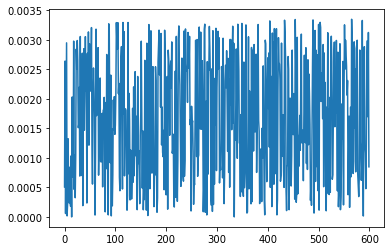

In [22]:
from scipy.integrate import odeint

ts = np.linspace(0.1, 1., 100)              ## times 
result = odeint(func = real_differential_system, 
                y0 = coeff_list_t0, 
                t = ts,
                args = ((param_list,)))

plt.plot(result[0])

In [11]:

ts = np.linspace(0.1, 1., 100)
y0 = coeff_list_t0

def complex_differential_system(cohr_vector_t0, t, parameters):
    """
    This module sets up the system of time-dependent differential
    equations, given by 
    
    dC/dt = -1j * M(t)*c(t),
    
    wherein M(t) is the coherence-weight matrix. 
    In accordance with Scipy.Odeint's documentation, this module takes
    as input the following parameters, 
    
    *** 1. cohr_vector_t0: an initial configuration of weights for the coherences at time zero, 
           such that this configuration has trace one.
    *** 2. t: time
    *** 3. parameters: a dictionary containing three parameters:
                        ☼*☼: the total number of coherences in the system,
                        ☼*☼: the chosen p-factor, the weight for the 
                             perturbation Hamiltonian, Sigma. 
                        ☼*☼: the power law factor used in the approximation.
    
    ===> Returns: an array of numbers
    
    """
    return -1j * me.gen_func_even_cohr_M_matrix(parameters = parameters,
                                       init_configurations = cohr_vector_t0, 
                                       timet = t,
                                       closed_boundary_conditions = False,
                                       visualization = False,
                                       as_qutip_qobj = False) @ (cohr_vector_t0)

def jacobian_sysdiffeq(cohr_vector_t0, t, parameters):
    return 

In [6]:
from scipy.integrate import ode

y0, t0 = [1.0j, 2.0], 0

def f(t, y, arg1):
    return [1j*arg1*y[0] + y[1], -arg1*y[1]**2]
def jac(t, y, arg1):
    return [[1j*arg1, 1], [0, -arg1*2*y[1]]]


r = ode(f, jac).set_integrator('zvode', method='bdf', with_jacobian=True)
r.set_initial_value(y0, t0).set_f_params(2.0).set_jac_params(2.0)

t1 = 10
dt = 1

while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    print(r.t, r.y)

1.0 [-0.7+0.2j  0.4+0.j ]
2.0 [0.2-0.5j 0.2+0.j ]
3.0 [0.5+0.5j 0.2+0.j ]
4.0 [-0.6+0.3j  0.1+0.j ]
5.0 [0. -0.6j 0.1+0.j ]
6.0 [0.6+0.3j 0.1+0.j ]
7.0 [-0.5+0.4j  0.1+0.j ]
8.0 [-0.2-0.6j  0.1+0.j ]
9.0 [0.6+0.2j 0.1+0.j ]
10.0 [-0.4+0.6j  0. +0.j ]


# Tests y fallos :(

In [23]:
Preguntas:
    
    1. La matrix M tiene que depender con el tiempo me parece, si A, B y C lo hacen: Check 
    2. Como tendría que implementar la norma???: Check
    3. Empezar a jugar con los parámetros: Checkn't
    
m+2 vs m+2 : Check
** reescribir la matriz en tèrminos de los c_pares. : Check

SyntaxError: invalid syntax (3991330021.py, line 1)

In [45]:
def generating_function_even_cohr_M_matrix(parameters, init_configuration, timespan, 
                                           closed_boundary_conditions = False):
    
    M = parameters["total_no_cohrs"]; p = parameters["p_factor"]; a = parameters["power_law_factor"]
    cm_list = init_configuration
    m_matrix_list = []; t = timespan;
    
    for m in range(M):
        if m == 0:
            m_matrix_list.append(np.array([diag_mm_matrix_elmt(m,t,a)] 
                                    + [A_mmplustwo_matrix_elmt(m+2,t,a)] + [0 for k in range(int((M-3)/2))])) 
        if m == 1:
            local_list = [0] + [diag_mm_matrix_elmt(m,t,a)] + [A_mmplustwo_matrix_elmt(m+2, t, a)]
            local_length = len(np.array(local_list))
            m_matrix_list.append(np.array(local_list + [0 for k in range(int(M/2 + 1)-local_length)]))
        if (m > 1) and (m < M - 2):  
            local_list = [0 for j in range(m-2)]; local_length = len(local_list)
            local_list += ([B_mmminustwo_matrix_elmt(-m-2,t,a)] + [diag_mm_matrix_elmt(m,t,a)] 
                        + [A_mmplustwo_matrix_elmt(m+2,t,a)])
            local_list += [0 for j in range(int(M/2+1)-local_length - 5)]
            m_matrix_list.append(np.array(local_list))
        if m == M - 2: 
            m_matrix_list.append(np.array([0 for i in range(int(M/2)-2)] + [B_mmminustwo_matrix_elmt(-m-2,t,a)]  
                                 + [diag_mm_matrix_elmt(m,t,a)] + [0]))
        if m == M - 1:
            m_matrix_list.append(np.array([0 for i in range(int(M/2)-2)] + [B_mmminustwo_matrix_elmt(-m-2,t,a)] + [0] 
                                 + [diag_mm_matrix_elmt(m,t,a)]))
    return (m_matrix_list)


In [72]:
v = [np.random.rand() for i in range(5)]
def example_matrix(t, p):
    return (t+p) * np.identity(5) 

def example_diff_eq(v, t, p):
    return example_matrix(t, p).dot(v)

ts = np.linspace(0., 10., 100)
result = odeint(func = example_diff_eq, 
                y0 = v, 
                t = ts,
                args = (p,))

In [4]:
A = np.array([-1,2,3])
sum(A)

4

In [ ]:
# Si la matrix M(t) = M para todo t, uso la propiedad de semigrupo y ya fue

def semigroup_phit_and_rhot_sol(coeff_list_t0, Mtensor, ts):
    coeff_at_timet_list = []
    coeff_at_timet_list.append(np.array(coeff_list_t0))
    
    for i in range(1, len(ts)-1):
        try: 
            a = (ts[i+1] * Mtensor).expm() * coeff_list_t0[0]
            coeff_at_timet_list.append(a)
        #if (Exception):
        #   continue 
    return coeff_at_timet_list    

# Si la matrix M(t) fuese no constante, odeints

from scipy.integrate import ode
import random

def F(y, t, Mtensor):
    return Mtensor.dot(y)

real_Mtensor = (np.real(Mtensor))
ts1 = np.linspace(0, 500, 200)
result = odeint(func=F, y0=coeff_list_t0, t= ts1 , args=(real_Mtensor,))
plt.figure(figsize=(7, 4))

for i in range(len(total_no_spins)):
    plt.plot(ts1, result[:,i], label=r'$c_{(%d)}(t)$'%i)

plt.xlabel("t")
plt.ylabel("Phi(t)")
plt.legend()

